In [101]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [106]:
# Load the model
model = load_model('/kaggle/input/model_/tensorflow2/default/1/resnet50.h5')

In [134]:
# Load and preprocess image
img_path = "/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust4.JPG"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = (tf.keras.preprocessing.image.img_to_array(img) / 255.0).reshape(1,224,224,3)  # Normalize to [0,1]

In [135]:
y_pred=model.predict(img)
y_pred=y_pred.argmax(axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([2])

In [138]:
# Grad-CAM heatmap function
def gradCAM_heatmap1(img, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, prediction = grad_model(img)
        pred_idx = tf.argmax(prediction[0])
        class_channel = prediction[:, pred_idx]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()


In [136]:
def draw_gradcam_fill_and_outline(heatmap, original_img, threshold_ratio=0.5, 
                                   fill_color=(255, 150, 150), outline_color=(0,255, 0),
                                   fill_alpha=0.4, outline_thickness=1):
    # Convert float image to uint8 if needed
    if original_img.max() <= 1.0:
        img_uint8 = (original_img * 255).astype(np.uint8)
    else:
        img_uint8 = original_img.copy()

    # Resize and threshold heatmap
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    threshold = int(threshold_ratio * 255)
    _, binary_mask = cv2.threshold(heatmap_resized, threshold, 255, cv2.THRESH_BINARY)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    # Create fill overlay
    overlay = np.full_like(img_uint8, fill_color, dtype=np.uint8)
    mask_3ch = np.stack([cleaned_mask]*3, axis=-1) // 255
    filled_img = np.where(mask_3ch, cv2.addWeighted(img_uint8, 1 - fill_alpha, overlay, fill_alpha, 0), img_uint8)

    # Draw contours (outline)
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = cv2.drawContours(filled_img.copy(), contours, -1, outline_color, outline_thickness)

    # Return in original scale
    return (outlined / 255.0) if original_img.max() <= 1.0 else outlined


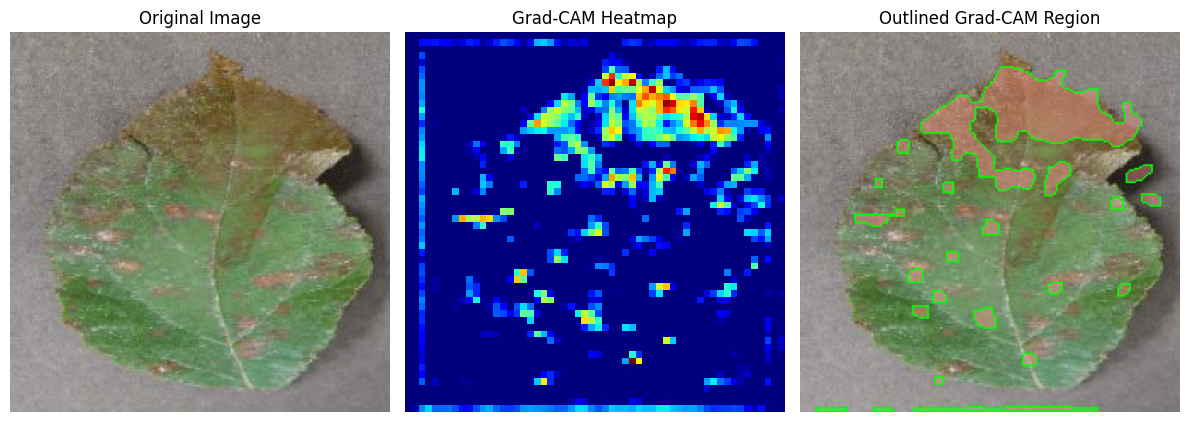

In [143]:
# Generate Grad-CAM heatmap
heatmap = gradCAM_heatmap1(img.reshape(1, 224, 224, 3),model, last_conv_layer_name="conv2d_16")

outlined_img = draw_gradcam_fill_and_outline(heatmap, img.reshape(224, 224, 3), threshold_ratio=0.03)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img.reshape(224,224,3))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Outlined Grad-CAM Region")
plt.imshow(outlined_img)
plt.axis('off')

plt.tight_layout()
plt.show()